# 👖 変分オートエンコーダ - Fashion MNIST

In [ ]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchinfo | tail -n 1

In [ ]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import japanize_matplotlib
import torchvision
import torch
import torchinfo
import random
from torch import nn
from torch.utils.data import DataLoader
import sys
print(sys.version)
print(torch.__version__)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
2.5.1+cu121


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # MPSを使用する場合の設定
        torch.backends.mps.deterministic = True
    elif torch.cuda.is_available():
        # CUDAが利用可能な場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# シード値を設定
set_seed(123)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cuda


## 0. パラメータ

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 10
BETA = 500

## 1. データの準備

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Pad(padding=2),  # 2ピクセルのパディングを追加
    torchvision.transforms.ToTensor(),
])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)


CLASSES = np.array([
        "Tシャツ／トップス",
        "ズボン",
        "プルオーバー", # 頭から被って着る服
        "ドレス",
        "コート",
        "サンダル",
        "シャツ",
        "スニーカー",
        "バッグ",
        "アンクルブーツ", # かかとが隠れる丈のブーツ
        ])

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Pad(padding=2, fill=0, padding_mode=constant)
               ToTensor()
           )


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

(1, 32, 32)


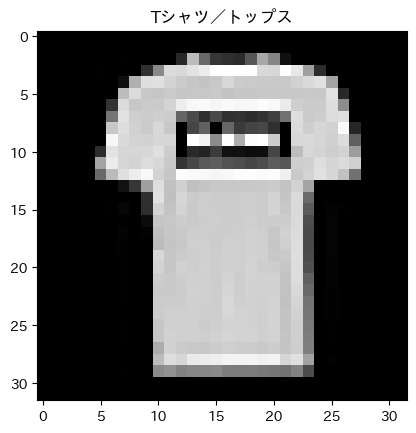

In [ ]:
print(trainset)
# データ確認
display(trainset[0][0])
# サイズ確認
print(np.array(trainset[0][0]).shape)
# データの可視化
plt.imshow(trainset[1][0].permute(1,2,0), cmap='gray')
plt.title(CLASSES[trainset[1][1]])
plt.show()

## 2. 変分オートエンコーダを構築

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, kernel_size=(3, 3), out_channels=32, padding=1, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, kernel_size=(3, 3), out_channels=64, padding=1, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, kernel_size=(3, 3), out_channels=128, padding=1, stride=2)

        self.flatten = nn.Flatten()

        self.fc_mean = nn.Linear(in_features=4 * 4 * 128, out_features=EMBEDDING_DIM)
        self.fc_log_var = nn.Linear(in_features=4 * 4 * 128, out_features=EMBEDDING_DIM)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.flatten(x)

        z_means = self.fc_mean(x)
        z_log_vars = self.fc_log_var(x)
        z = self.sample_gaussian(z_means, z_log_vars)

        return z, z_means, z_log_vars

    def sample_gaussian(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=EMBEDDING_DIM, out_features=4 * 4 * 128)
        self.deconv1 = nn.ConvTranspose2d(in_channels=128, kernel_size=(3, 3), out_channels=128, padding=1, output_padding=1, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, kernel_size=(3, 3), out_channels=64, padding=1, output_padding=1, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, kernel_size=(3, 3), out_channels=32, padding=1, output_padding=1, stride=2)
        self.conv1 = nn.Conv2d(in_channels=32, kernel_size=(3, 3), out_channels=1, padding=1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 4, 4)
        x = self.deconv1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        x = self.relu(x)
        x = self.deconv3(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.sigmoid(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z, z_means, z_log_vars = self.encoder(x)
        reconstructions = self.decoder(z)
        return reconstructions, z_means, z_log_vars

def loss_function(reconstructions, targets, z_means, z_log_vars, beta):
    # 再構成損失
    reconstruction_loss = nn.functional.binary_cross_entropy(input=reconstructions, target=targets, reduction='none')
    reconstruction_loss = reconstruction_loss.flatten(start_dim=1).mean(dim=1).mean()

    # KLダイバージェンス損失
    kl_divergence =  -0.5 * torch.sum((1 + z_log_vars - z_means.pow(2) - z_log_vars.exp()), axis=1).mean()

    return beta * reconstruction_loss + kl_divergence

In [ ]:
vae = VAE()
encoder = vae.encoder
decoder = vae.decoder

In [ ]:
# エンコーダの設計
torchinfo.summary(encoder.eval(), input_size=(1, 1, 32, 32), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 2]                    --
├─Conv2d: 1-1                            [1, 32, 16, 16]           320
├─ReLU: 1-2                              [1, 32, 16, 16]           --
├─Conv2d: 1-3                            [1, 64, 8, 8]             18,496
├─ReLU: 1-4                              [1, 64, 8, 8]             --
├─Conv2d: 1-5                            [1, 128, 4, 4]            73,856
├─ReLU: 1-6                              [1, 128, 4, 4]            --
├─Flatten: 1-7                           [1, 2048]                 --
├─Linear: 1-8                            [1, 2]                    4,098
├─Linear: 1-9                            [1, 2]                    4,098
Total params: 100,868
Trainable params: 100,868
Non-trainable params: 0
Total mult-adds (M): 2.46
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.40
Estimated Total Size (MB): 0.

In [ ]:
# エンコーダの設計
torchinfo.summary(decoder.eval(), input_size=(1, 2), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1, 1, 32, 32]            --
├─Linear: 1-1                            [1, 2048]                 6,144
├─ConvTranspose2d: 1-2                   [1, 128, 8, 8]            147,584
├─ReLU: 1-3                              [1, 128, 8, 8]            --
├─ConvTranspose2d: 1-4                   [1, 64, 16, 16]           73,792
├─ReLU: 1-5                              [1, 64, 16, 16]           --
├─ConvTranspose2d: 1-6                   [1, 32, 32, 32]           18,464
├─ReLU: 1-7                              [1, 32, 32, 32]           --
├─Conv2d: 1-8                            [1, 1, 32, 32]            289
├─Sigmoid: 1-9                           [1, 1, 32, 32]            --
Total params: 246,273
Trainable params: 246,273
Non-trainable params: 0
Total mult-adds (M): 47.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.99
Estimated Total Size (MB):

In [ ]:
# 全体の設計
torchinfo.summary(vae.eval(), input_size=(1, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 1, 32, 32]            --
├─Encoder: 1-1                           [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 16, 16]           320
│    └─ReLU: 2-2                         [1, 32, 16, 16]           --
│    └─Conv2d: 2-3                       [1, 64, 8, 8]             18,496
│    └─ReLU: 2-4                         [1, 64, 8, 8]             --
│    └─Conv2d: 2-5                       [1, 128, 4, 4]            73,856
│    └─ReLU: 2-6                         [1, 128, 4, 4]            --
│    └─Flatten: 2-7                      [1, 2048]                 --
│    └─Linear: 2-8                       [1, 2]                    4,098
│    └─Linear: 2-9                       [1, 2]                    4,098
├─Decoder: 1-2                           [1, 1, 32, 32]            --
│    └─Linear: 2-10                      [1, 2048]                 6,1

## 3. 変分オートエンコーダの学習

In [ ]:
opt = torch.optim.Adam(vae.parameters(), lr=0.001)
criterion = loss_function

In [ ]:
vae = vae.to(device)
vae.train()
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)
        opt.zero_grad()
        reconstructions, z_means, z_log_vars = vae(inputs)
        loss = criterion(reconstructions, inputs, z_means, z_log_vars, BETA)  # 元の入力と出力を比較してロスを計算
        loss.backward() # backpropagation
        opt.step() # モデルのパラメータ更新

        running_loss += loss.item() # 誤差の値を加算

    # epoch終了時点での誤算の平均値
    print(f'epoch {epoch + 1} loss: {running_loss / len(trainset):.4f}')

epoch 1 loss: 1.4835
epoch 2 loss: 1.3422
epoch 3 loss: 1.3277
epoch 4 loss: 1.3210
epoch 5 loss: 1.3158
epoch 6 loss: 1.3116
epoch 7 loss: 1.3089
epoch 8 loss: 1.3067
epoch 9 loss: 1.3038
epoch 10 loss: 1.3020


## 4. エンコーダ部による埋込み

In [ ]:
n_to_predict = 5000
vae.eval()
test_data = [testset[i][0] for i in range(n_to_predict)]
test_labels = [testset[i][1] for i in range(n_to_predict)]
test_data = torch.stack(test_data)
print(test_data.shape)

embeddings = vae.encoder(test_data.to(device))[0].cpu().detach().numpy()

torch.Size([5000, 1, 32, 32])


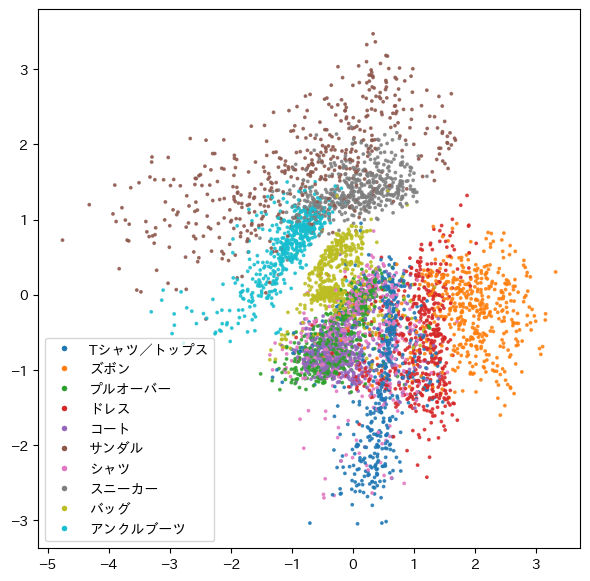

In [ ]:
figsize = 7
plt.figure(figsize=(figsize, figsize))

scatter = plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=test_labels,
    cmap="tab10",
    alpha=0.8,
    s=3,
)

# 凡例を追加
handles = [plt.Line2D([0], [0], marker='o', color='w', label=CLASSES[i],
                      markerfacecolor=plt.cm.tab10(i / len(CLASSES)), markersize=5)
           for i in range(len(CLASSES))]
plt.legend(handles=handles)

plt.show()

## 5. デコーダ部を使った画像の生成

In [ ]:
# 既存の埋め込みの各次元から値の上限・下限を得る
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# 潜在空間の点を一様分布でサンプリングする
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [ ]:
# サンプルされた点をデコードする．
reconstructions = vae.decoder(torch.tensor(sample).float().to(device))

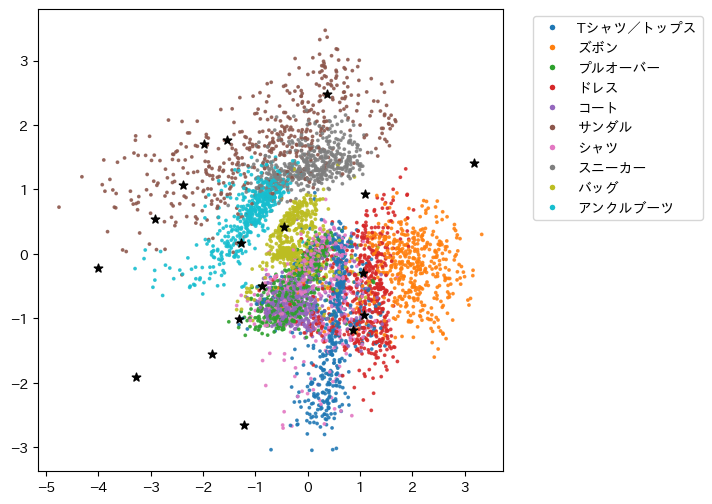

In [ ]:
# デコード（生成）されたプロットを描く
figsize = 6
plt.figure(figsize=(figsize, figsize))

scatter = plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=test_labels,
    cmap="tab10",
    alpha=0.8,
    s=3,
)

# 凡例を追加
handles = [plt.Line2D([0], [0], marker='o', color='w', label=CLASSES[i],
                      markerfacecolor=plt.cm.tab10(i / len(CLASSES)), markersize=5)
           for i in range(len(CLASSES))]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), fontsize=10)

plt.scatter(sample[:, 0], sample[:, 1], c='black', marker='*', alpha=1, s=40)
plt.show()

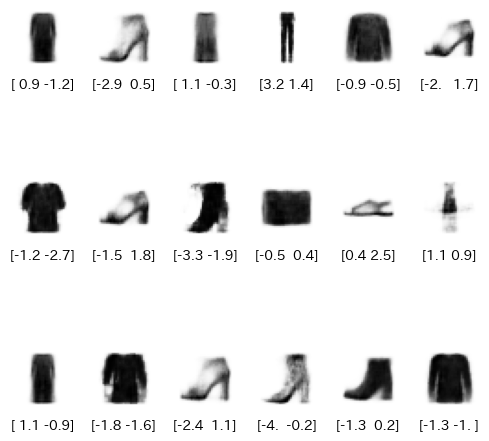

In [ ]:
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i+1)
    ax.set_axis_off()
    ax.text(0.5, -0.35, str(np.round(sample[i, :], 1)), fontsize=10, ha="center", transform=ax.transAxes)
    ax.imshow(reconstructions[i, :, :].permute(1, 2, 0).cpu().detach().numpy(), cmap="Greys")